### calculates M1, Z1 and SAM (40S - 65S zonal mean) from the GCM data 

### ECMWF for now 

In [1]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr

### plotting 
from matplotlib import pyplot as plt


In [2]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 


In [8]:
sys.path.append(str(HOME.joinpath('research/Smart_Ideas/code')))

In [9]:
from ml4seas import GCM

In [10]:
GCM.preprocess_ECMWF_nc??

Signature: GCM.preprocess_ECMWF_nc(dset)
Source:   
def preprocess_ECMWF_nc(dset): 
    """
    small utility function to pre-process 
    the ECMWf netcdf files (1981 - 2019)
    """

    import numpy as np 

    # 1: set the initial time 
    dset = dset.expand_dims('init_time')
    dset['init_time'] = (('init_time'), [dset.time.data[0]])
    # 2: rename the dimensions 
    d = {}
    d['latitude'] = 'lat'
    d['longitude'] = 'lon'
    d['number'] = 'member'
    d['time'] = 'step'
    dset = dset.rename(d)
    # 3: replace the step variable 
    dset['step'] = (('step'), np.arange(len(dset.step.data)))
    # 4: flip the latitudes 
    if (dset.lat.data[0] > dset.lat.data[-1]): 
        dset = dset.sortby('lat')
    # if more than 25 members, only select 25 members 
    if len(dset.member.data) > 25:
        dset = dset.isel(member=slice(0, 25))
    return dset
File:      ~/research/Smart_Ideas/code/ml4seas/GCM/preprocess_ECMWF_nc.py
Type:      function


### path to the raw data MSLP from ECMWF 

In [3]:
dpath_raw = pathlib.Path('/media/nicolasf/END19101/data/GCMs/downloads/ECMWF/MSLP/')

In [4]:
lfiles_gcm_raw = list(dpath_raw.glob("*.nc"))

In [14]:
dset = xr.open_mfdataset(lfiles_gcm_raw, concat_dim='init_time', combine='nested', parallel=True, preprocess=GCM.preprocess_ECMWF_nc)

In [15]:
dset

,Array,Chunk
Bytes,18.30 GB,39.10 MB
Shape,"(468, 6, 25, 181, 360)","(1, 6, 25, 181, 360)"
Count,2844 Tasks,468 Chunks
Type,float32,numpy.ndarray


### calculates the ensemble mean 

In [17]:
dsetm = dset.mean('member')

### calculates the SAM

This version of the SAM is calculated using SLP from the 20CRV2c. (SAM) is defined as the difference of zonal mean sea level pressure between 40°S and 65°S. The zonal means at 40°S and 65°S are each calculated. Each month's zonal mean is standardized by the mean/standard deviation determined for the climatological time period (1981-2010). Then, the 65°S value is subtracted from the 40°S value for each month. 

In [29]:
s40 = dsetm.sel(lat=-40).mean('lon')

In [30]:
s65 = dsetm.sel(lat=-65).mean('lon')

In [31]:
s65 = s65['msl'].to_dataframe().drop('lat', axis=1).unstack()

In [33]:
s40 = s40['msl'].to_dataframe().drop('lat', axis=1).unstack()

In [35]:
clims40 = s40.loc['1981':'2010',:]

In [36]:
clims65 = s65.loc['1981':'2010',:]

In [37]:
def demean(x): 
    z = (x - x.loc['1981':'2010',:].mean()) / x.loc['1981':'2010',:].std() 
    return z

In [38]:
s65 = s65.groupby(s65.index.month).apply(demean)

In [39]:
s40 = s40.groupby(s40.index.month).apply(demean)

In [40]:
SAM = s40 - s65

In [41]:
SAM

msl                                                  
step               0         1         2         3         4         5
init_time                                                             
1981-01-01  1.586960  1.870237 -0.450457  2.206864 -1.322341 -2.124504
1981-02-01  1.586646  1.578326 -0.715241  0.048084 -0.028632 -2.608933
1981-03-01 -3.983094 -1.196383 -0.919429  0.073503  2.861193  0.539448
1981-04-01 -4.695190  0.553222  0.222350 -1.476104 -1.397238 -2.071118
1981-05-01 -1.553262 -2.358921 -2.805771 -0.602771 -2.235488 -1.119768
...              ...       ...       ...       ...       ...       ...
2019-08-01 -2.563732 -1.817328 -1.755345 -0.620728  0.849777  0.845970
2019-09-01 -0.868649 -5.102954 -2.861491 -0.492553 -0.428645  0.173080
2019-10-01  0.091929 -0.984514  1.048517  0.195933  0.059890  2.672517
2019-11-01 -6.618242 -3.650652  0.018487  1.626855  1.080760 -0.748774
2019-12-01 -3.924686 -2.237026 -0.925307  0.144878  1.297290  2.248375

[468 rows x 6 columns]

In [53]:
SAM.xs(0, axis=1, level=1)

,msl
init_time,
1981-01-01,1.586960
1981-02-01,1.586646
1981-03-01,-3.983094
1981-04-01,-4.695190
1981-05-01,-1.553262
...,...
2019-08-01,-2.563732
2019-09-01,-0.868649
2019-10-01,0.091929


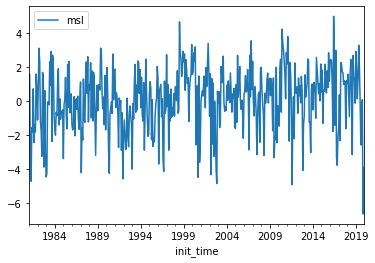

In [45]:
SAM.xs(0, axis=1, level=1).plot()

### get the SAM index from NOAA for comparison 

In [46]:
url = "https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/aao/monthly.aao.index.b79.current.ascii.table"

In [47]:
SAM_noaa = pd.read_table(url, sep=r"\s+") 

In [48]:
SAM_noaa = SAM_noaa.stack()

In [49]:
SAM_noaa.index = pd.date_range(start='1979-01-01', freq='MS', periods=len(SAM_noaa))

In [50]:
SAM_noaa = SAM_noaa.to_frame(name='SAM')

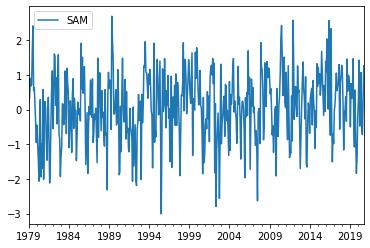

In [51]:
SAM_noaa.plot()

In [58]:
pd.concat([SAM.xs(0, axis=1, level=1), SAM_noaa], axis=1).corr()

,msl,SAM
msl,1.000000,0.652588
SAM,0.652588,1.000000


In [60]:
SAM.tail()

msl                                                  
step               0         1         2         3         4         5
init_time                                                             
2019-08-01 -2.563732 -1.817328 -1.755345 -0.620728  0.849777  0.845970
2019-09-01 -0.868649 -5.102954 -2.861491 -0.492553 -0.428645  0.173080
2019-10-01  0.091929 -0.984514  1.048517  0.195933  0.059890  2.672517
2019-11-01 -6.618242 -3.650652  0.018487  1.626855  1.080760 -0.748774
2019-12-01 -3.924686 -2.237026 -0.925307  0.144878  1.297290  2.248375

### saves the SAM index to disk

In [61]:
opath = pathlib.Path("/media/nicolasf/END19101/data/observational_indices/SAM_GCM") 

In [62]:
if not opath.exists():
    opath.mkdir(parents=True)

In [69]:
SAM.columns = pd.MultiIndex.from_product([['SAM'], range(6)])

In [71]:
SAM.to_csv(opath.joinpath("SAM_ECMWF.csv")) 

### Now calculates the M1 and Z1 indices 

**M1:** 

→ Hobart: 42.8821° S, 147.3272° E 
→ Chatham Island: 44.0058° S, 176.5401° W 

**Z1:** 

→ Auckland: 36.8483° S, 174.7625° E 
→ Christchurch: 43.5320° S, 172.6397° E 

In [77]:
M1 = dsetm.sel(lat=-42.8821, lon=147.3272, method='nearest') - dsetm.sel(lat=-44.0058, lon=176.5401, method='nearest')

In [78]:
M1 = M1['msl'].to_dataframe().unstack()

In [80]:
M1.columns = pd.MultiIndex.from_product([['M1'], range(6)])

### Z1

In [84]:
Z1 = dsetm.sel(lat=-36.8483, lon=174.7625, method='nearest') - dsetm.sel(lat=-43.5320, lon=172.6397, method='nearest')

In [85]:
Z1 = Z1['msl'].to_dataframe().unstack()

In [86]:
Z1.columns = pd.MultiIndex.from_product([['Z1'], range(6)])

### removes the climatology 

In [87]:
M1 = M1.groupby(M1.index.month).apply(demean)

In [88]:
Z1 = Z1.groupby(Z1.index.month).apply(demean)

### compare with the indices calculated by Brett from the station data 

In [90]:
Indices_Brett = pd.read_csv("/home/nicolasf/research/Smart_Ideas/code/rainml/data/preprocessed/monthly.csv", index_col=0, parse_dates=True) 

In [91]:
pd.concat([Indices_Brett.loc[:,['m1_0']], M1.xs(0, axis=1, level=1)], axis=1).corr()

,m1_0,M1
m1_0,1.000000,0.484603
M1,0.484603,1.000000


In [92]:
pd.concat([Indices_Brett.loc[:,['z1_0']], Z1.xs(0, axis=1, level=1)], axis=1).corr()

,z1_0,Z1
z1_0,1.000000,0.575325
Z1,0.575325,1.000000


In [93]:
opath = pathlib.Path("/media/nicolasf/END19101/data/observational_indices/M1_ECMWF") 

In [94]:
if not opath.exists():
    opath.mkdir(parents=True)

In [95]:
M1.to_csv(opath.joinpath("M1_ECMWF.csv")) 

In [96]:
opath = pathlib.Path("/media/nicolasf/END19101/data/observational_indices/Z1_ECMWF")

In [97]:
if not opath.exists():
    opath.mkdir(parents=True)

In [98]:
Z1.to_csv(opath.joinpath("Z1_ECMWF.csv")) 

In [99]:
!pwd

/home/nicolasf/research/Smart_Ideas/code/observational_indices/notebooks
